In [1]:
pwd

'/home/jslee/mammo_code'

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import torch

In [4]:
import logging
import os
import sys
import tempfile
from glob import glob
import random
import pickle
import matplotlib.pyplot as plt
import pandas as pd
import re
import numpy as np
from tqdm import tqdm
import cv2
import sys

import torch
from PIL import Image
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter

import monai
from monai.data import ArrayDataset, create_test_image_2d, decollate_batch
from monai.inferers import sliding_window_inference
from monai.metrics import DiceMetric
from monai.transforms import (
    Activations,
    AddChannel,
    AsDiscrete,
    Compose,
    LoadImage,
    RandRotate90,
    RandSpatialCrop,
    ScaleIntensity,
    NormalizeIntensity,
    #EnsureType,
    Resize
)
from monai.visualize import plot_2d_or_3d_image

/home/jslee/miniconda3/lib/python3.9/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: libtorch_cuda_cu.so: cannot open shared object file: No such file or directory
  warn(f"Failed to load image Python extension: {e}")


In [5]:
import getfinal as f

In [6]:
# Set deterministic training for reproducibility
seed = 92
torch.manual_seed(seed)
random.seed(seed)
np.random.seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [7]:
monai.config.print_config()

MONAI version: 0.6.0
Numpy version: 1.24.1
Pytorch version: 1.13.0.post200
MONAI flags: HAS_EXT = False, USE_COMPILED = False
MONAI rev id: 0ad9e73639e30f4f1af5a1f4a45da9cb09930179

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: NOT INSTALLED or UNKNOWN VERSION.
scikit-image version: NOT INSTALLED or UNKNOWN VERSION.
Pillow version: 9.4.0
Tensorboard version: 2.11.0
gdown version: NOT INSTALLED or UNKNOWN VERSION.
TorchVision version: 0.14.0
ITK version: NOT INSTALLED or UNKNOWN VERSION.
tqdm version: 4.64.1
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 5.9.4
pandas version: 1.5.1
einops version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



In [8]:
df_image = pd.read_csv("csv/train.csv")

In [9]:
df_density = df_image[df_image.dataset_density=="yes"]
len(df_density)

8082

In [10]:
df_density.value_counts("CENTER")

CENTER
ncc2020    5979
asan       2103
dtype: int64

In [11]:
def get_dens(image, segment):
        ta = np.sum(image!=0)
        cu = np.sum(segment[1]==1) / ta * 100
        ac = np.sum(segment[2]==1) / ta * 100
        cc = np.sum(segment[3]==1) / ta * 100
        return [cu + ac + cc, ac + cc, cc]

class MyDataset(torch.utils.data.Dataset):
    def __init__(self, images, train_imtrans, segs, train_segtrans):
        self.images = images
        self.train_imtrans = train_imtrans
        self.segs = segs
        self.train_segtrans = train_segtrans

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        image = self.train_imtrans(self.images[index])
        seg = self.train_segtrans(self.segs[index])

        return image, seg.astype(int) # density

train_imtrans = Compose([LoadImage(image_only=True), AddChannel(), ScaleIntensity()])
train_segtrans = Compose([LoadImage(image_only=True)])
val_imtrans = Compose([LoadImage(image_only=True), AddChannel(), ScaleIntensity()])
val_segtrans = Compose([LoadImage(image_only=True)])

dicom_imtrans = Compose(ScaleIntensity())
post_trans = Compose([Activations(sigmoid=True), AsDiscrete(threshold_values=True)])

In [12]:
def pad_to_square(a, LR, pad_value=0):
    m = a.reshape((a.shape[0], -1))
    padded = pad_value * np.ones(2 * [max(m.shape)], dtype=m.dtype)
    if  LR != 0 :
        padded[0:m.shape[0], 0:m.shape[1]] = m # Left
    else :
        padded[:,-m.shape[1]:] = m # Right
    return padded

def get_resize(image, dim, LR):
    image_square = pad_to_square(image, LR)
    image_resize = cv2.resize(image_square, dim, interpolation = cv2.INTER_AREA)
    return image_resize

In [13]:
def one_hot_reverse(segs):
    segment = segs[1].copy()
    segment[segs[0]==1] = 0    
    segment[segs[2]==1] = 2    
    segment[segs[3]==1] = 3
    return segment

In [14]:
def plot_seg(im, segment):
    plt.imshow(im, cmap=plt.cm.gray)
    plt.imshow(segment, cmap="jet", alpha=0.5) #, interpolation='bilinear')

In [15]:
def get_predict(model, dicom, roi_size = (96, 96), sw_batch_size = 4):
    image = f.get_final5(dicom)
    LR = image[0,0]
    image = get_resize(image/image.max(),dim=(512,512),LR=LR)
    image = torch.Tensor(dicom_imtrans(image)[None,None,:])
    model.eval()
    with torch.no_grad():
        #roi_size = (96, 96)
        #sw_batch_size = 4
        #val_outputs = sliding_window_inference(image, roi_size, sw_batch_size, model)
        val_outputs = model(image)
        #val_outputs = val_outputs['out']
        val_outputs = post_trans(val_outputs)
    image = image.to("cpu").numpy()[0][0]
    segment = one_hot_reverse(val_outputs.to("cpu").numpy().astype(int)[0])    
    return image, segment
def plot_predict(model, dicom, roi_size = (96, 96), sw_batch_size = 4):
    image, segment = get_predict(model, dicom, roi_size = roi_size, sw_batch_size = sw_batch_size)
    plot_seg(image, segment)
def calculate_predict(model, dicom, thres, gmm=0, roi_size = (96, 96), sw_batch_size = 4):
    _, _, density = f.get_final5(dicom, gmm=gmm, thres=thres)
    
    image, segment = get_predict(model, dicom, gmm=gmm, roi_size = roi_size, sw_batch_size = sw_batch_size)
    density_pixel = [np.sum(image!=0), np.sum(segment>=1), np.sum(segment>=2), np.sum(segment>=3)]
    scaling = float(f.get_info(dicom, 7)[0])
    density_area = [i * scaling / 1000 for i in density_pixel]
    density_percent = (density_pixel /density_pixel[0] * 100).tolist()
    density_pred = {"pixel":density_pixel, "area":density_area, "percent":density_percent}
    density_pred['area'] = (density_pred['area'] / density_pred['pixel'][0] * density['pixel'][0]).tolist()

    return density, density_pred

In [16]:
images_train = df_density[df_density.dataset=="train"].file_image.tolist()
images_val = df_density[df_density.dataset=="val"].file_image.tolist()
images_test = df_density[df_density.dataset=="test"].file_image.tolist()

segs_train = [re.sub('image','segment',i) for i in images_train]
segs_val = [re.sub('image','segment',i) for i in images_val]
segs_test = [re.sub('image','segment',i) for i in images_test]

In [17]:
check_ds = MyDataset(images_train, train_imtrans, segs_train, train_segtrans)
check_loader = DataLoader(check_ds, batch_size=5)
im, seg = monai.utils.misc.first(check_loader)
print(im.shape, seg.shape)

torch.Size([5, 1, 256, 256]) torch.Size([5, 4, 256, 256])


In [18]:
BATCH_SIZE = 128
train_ds = MyDataset(images_train, train_imtrans, segs_train, train_segtrans)
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=8, pin_memory=torch.cuda.is_available(), drop_last=True)

val_ds = MyDataset(images_val, val_imtrans, segs_val, val_segtrans)
val_loader = DataLoader(val_ds, batch_size=4, num_workers=4, pin_memory=torch.cuda.is_available())

In [19]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = monai.networks.nets.UNet(
    dimensions=2,
    in_channels=1,
    out_channels=4,
    channels=(16, 32, 64, 128, 256),
    strides=(2, 2, 2, 2),
    num_res_units=2,
)

if torch.cuda.device_count() > 1:
    print("Using", torch.cuda.device_count(), "GPUs")
    model = torch.nn.DataParallel(model, device_ids = [0, 1, 2])
model = model.to(device)

Using 3 GPUs


In [20]:
optimizer = torch.optim.Adam(model.parameters(), 1e-3)
loss_function = monai.losses.DiceFocalLoss(sigmoid=True) #lambda_dice=0.5, lambda_focal=1.0
dice_metric = DiceMetric(include_background=True, reduction="mean")

In [21]:
# start a typical PyTorch training
val_interval = 2
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = list()
metric_values = list()

In [22]:
name = 'density-unet'
path = "model/"+ name + ".pth"
path_hist = "model/"+ name + ".csv"
path_pdf = "model/"+ name + "/"

In [28]:
import pydicom
import pylibjpeg

5651


/home/jslee/miniconda3/lib/python3.9/site-packages/openjpeg/utils.py:176: UserWarning: The (7FE0,0010) Pixel Data contains a JPEG 2000 codestream with the optional JP2 file format header, which is non-conformant to the DICOM Standard (Part 5, Annex A.4.4)
  warnings.warn(


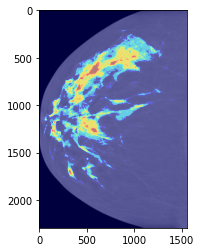

In [24]:
density = pd.read_csv("csv/density_asan-ncc.csv")
#i=random.choice(range(len(density)))
i=5651
print(i)
file = 'dicom/'+density.CENTER[i]+'/'+density.file[i]
thres = density[['thres_cu','thres_ac','thres_cc']].values[i].tolist()
final = f.get_final5(file, thres = thres)
plot_seg(final[0],final[1])
plt.savefig('5651.pdf', format='PDF')

In [25]:
#pip install pylibjpeg-openjpeg

----------
epoch 1/80
epoch 1 average loss: 0.7816
----------
epoch 2/80
epoch 2 average loss: 0.7440
saved new best metric model
current epoch: 2 current mean dice: 0.5136 best mean dice: 0.5136 at epoch 2


/home/jslee/miniconda3/lib/python3.9/site-packages/openjpeg/utils.py:176: UserWarning: The (7FE0,0010) Pixel Data contains a JPEG 2000 codestream with the optional JP2 file format header, which is non-conformant to the DICOM Standard (Part 5, Annex A.4.4)
  warnings.warn(


----------
epoch 3/80
epoch 3 average loss: 0.7182
----------
epoch 4/80
epoch 4 average loss: 0.6940
current epoch: 4 current mean dice: 0.5132 best mean dice: 0.5136 at epoch 2


/home/jslee/miniconda3/lib/python3.9/site-packages/openjpeg/utils.py:176: UserWarning: The (7FE0,0010) Pixel Data contains a JPEG 2000 codestream with the optional JP2 file format header, which is non-conformant to the DICOM Standard (Part 5, Annex A.4.4)
  warnings.warn(


----------
epoch 5/80
epoch 5 average loss: 0.6689
----------
epoch 6/80
epoch 6 average loss: 0.6434
saved new best metric model
current epoch: 6 current mean dice: 0.5327 best mean dice: 0.5327 at epoch 6


/home/jslee/miniconda3/lib/python3.9/site-packages/openjpeg/utils.py:176: UserWarning: The (7FE0,0010) Pixel Data contains a JPEG 2000 codestream with the optional JP2 file format header, which is non-conformant to the DICOM Standard (Part 5, Annex A.4.4)
  warnings.warn(


----------
epoch 7/80
epoch 7 average loss: 0.6201
----------
epoch 8/80
epoch 8 average loss: 0.6005
saved new best metric model
current epoch: 8 current mean dice: 0.5440 best mean dice: 0.5440 at epoch 8


/home/jslee/miniconda3/lib/python3.9/site-packages/openjpeg/utils.py:176: UserWarning: The (7FE0,0010) Pixel Data contains a JPEG 2000 codestream with the optional JP2 file format header, which is non-conformant to the DICOM Standard (Part 5, Annex A.4.4)
  warnings.warn(


----------
epoch 9/80
epoch 9 average loss: 0.5867
----------
epoch 10/80
epoch 10 average loss: 0.5728
saved new best metric model
current epoch: 10 current mean dice: 0.5539 best mean dice: 0.5539 at epoch 10


/home/jslee/miniconda3/lib/python3.9/site-packages/openjpeg/utils.py:176: UserWarning: The (7FE0,0010) Pixel Data contains a JPEG 2000 codestream with the optional JP2 file format header, which is non-conformant to the DICOM Standard (Part 5, Annex A.4.4)
  warnings.warn(


----------
epoch 11/80
epoch 11 average loss: 0.5628
----------
epoch 12/80
epoch 12 average loss: 0.5493
saved new best metric model
current epoch: 12 current mean dice: 0.6157 best mean dice: 0.6157 at epoch 12


/home/jslee/miniconda3/lib/python3.9/site-packages/openjpeg/utils.py:176: UserWarning: The (7FE0,0010) Pixel Data contains a JPEG 2000 codestream with the optional JP2 file format header, which is non-conformant to the DICOM Standard (Part 5, Annex A.4.4)
  warnings.warn(


----------
epoch 13/80
epoch 13 average loss: 0.5391
----------
epoch 14/80
epoch 14 average loss: 0.5219
saved new best metric model
current epoch: 14 current mean dice: 0.6269 best mean dice: 0.6269 at epoch 14


/home/jslee/miniconda3/lib/python3.9/site-packages/openjpeg/utils.py:176: UserWarning: The (7FE0,0010) Pixel Data contains a JPEG 2000 codestream with the optional JP2 file format header, which is non-conformant to the DICOM Standard (Part 5, Annex A.4.4)
  warnings.warn(


----------
epoch 15/80
epoch 15 average loss: 0.5071
----------
epoch 16/80
epoch 16 average loss: 0.4961
saved new best metric model
current epoch: 16 current mean dice: 0.6379 best mean dice: 0.6379 at epoch 16


/home/jslee/miniconda3/lib/python3.9/site-packages/openjpeg/utils.py:176: UserWarning: The (7FE0,0010) Pixel Data contains a JPEG 2000 codestream with the optional JP2 file format header, which is non-conformant to the DICOM Standard (Part 5, Annex A.4.4)
  warnings.warn(


----------
epoch 17/80
epoch 17 average loss: 0.4872
----------
epoch 18/80
epoch 18 average loss: 0.4783
saved new best metric model
current epoch: 18 current mean dice: 0.6631 best mean dice: 0.6631 at epoch 18


/home/jslee/miniconda3/lib/python3.9/site-packages/openjpeg/utils.py:176: UserWarning: The (7FE0,0010) Pixel Data contains a JPEG 2000 codestream with the optional JP2 file format header, which is non-conformant to the DICOM Standard (Part 5, Annex A.4.4)
  warnings.warn(


----------
epoch 19/80
epoch 19 average loss: 0.4676
----------
epoch 20/80
epoch 20 average loss: 0.4611
current epoch: 20 current mean dice: 0.6613 best mean dice: 0.6631 at epoch 18


/home/jslee/miniconda3/lib/python3.9/site-packages/openjpeg/utils.py:176: UserWarning: The (7FE0,0010) Pixel Data contains a JPEG 2000 codestream with the optional JP2 file format header, which is non-conformant to the DICOM Standard (Part 5, Annex A.4.4)
  warnings.warn(


----------
epoch 21/80
epoch 21 average loss: 0.4542
----------
epoch 22/80
epoch 22 average loss: 0.4474
saved new best metric model
current epoch: 22 current mean dice: 0.6730 best mean dice: 0.6730 at epoch 22


/home/jslee/miniconda3/lib/python3.9/site-packages/openjpeg/utils.py:176: UserWarning: The (7FE0,0010) Pixel Data contains a JPEG 2000 codestream with the optional JP2 file format header, which is non-conformant to the DICOM Standard (Part 5, Annex A.4.4)
  warnings.warn(


----------
epoch 23/80
epoch 23 average loss: 0.4414
----------
epoch 24/80
epoch 24 average loss: 0.4342
saved new best metric model
current epoch: 24 current mean dice: 0.6832 best mean dice: 0.6832 at epoch 24


/home/jslee/miniconda3/lib/python3.9/site-packages/openjpeg/utils.py:176: UserWarning: The (7FE0,0010) Pixel Data contains a JPEG 2000 codestream with the optional JP2 file format header, which is non-conformant to the DICOM Standard (Part 5, Annex A.4.4)
  warnings.warn(


----------
epoch 25/80
epoch 25 average loss: 0.4301
----------
epoch 26/80
epoch 26 average loss: 0.4206
saved new best metric model
current epoch: 26 current mean dice: 0.7127 best mean dice: 0.7127 at epoch 26


/home/jslee/miniconda3/lib/python3.9/site-packages/openjpeg/utils.py:176: UserWarning: The (7FE0,0010) Pixel Data contains a JPEG 2000 codestream with the optional JP2 file format header, which is non-conformant to the DICOM Standard (Part 5, Annex A.4.4)
  warnings.warn(


----------
epoch 27/80
epoch 27 average loss: 0.4151
----------
epoch 28/80
epoch 28 average loss: 0.3972
saved new best metric model
current epoch: 28 current mean dice: 0.7371 best mean dice: 0.7371 at epoch 28


/home/jslee/miniconda3/lib/python3.9/site-packages/openjpeg/utils.py:176: UserWarning: The (7FE0,0010) Pixel Data contains a JPEG 2000 codestream with the optional JP2 file format header, which is non-conformant to the DICOM Standard (Part 5, Annex A.4.4)
  warnings.warn(


----------
epoch 29/80
epoch 29 average loss: 0.3809
----------
epoch 30/80
epoch 30 average loss: 0.3703
current epoch: 30 current mean dice: 0.7329 best mean dice: 0.7371 at epoch 28


/home/jslee/miniconda3/lib/python3.9/site-packages/openjpeg/utils.py:176: UserWarning: The (7FE0,0010) Pixel Data contains a JPEG 2000 codestream with the optional JP2 file format header, which is non-conformant to the DICOM Standard (Part 5, Annex A.4.4)
  warnings.warn(


----------
epoch 31/80
epoch 31 average loss: 0.3534
----------
epoch 32/80
epoch 32 average loss: 0.3453
saved new best metric model
current epoch: 32 current mean dice: 0.7492 best mean dice: 0.7492 at epoch 32


/home/jslee/miniconda3/lib/python3.9/site-packages/openjpeg/utils.py:176: UserWarning: The (7FE0,0010) Pixel Data contains a JPEG 2000 codestream with the optional JP2 file format header, which is non-conformant to the DICOM Standard (Part 5, Annex A.4.4)
  warnings.warn(


----------
epoch 33/80
epoch 33 average loss: 0.3329
----------
epoch 34/80
epoch 34 average loss: 0.3254
saved new best metric model
current epoch: 34 current mean dice: 0.7553 best mean dice: 0.7553 at epoch 34


/home/jslee/miniconda3/lib/python3.9/site-packages/openjpeg/utils.py:176: UserWarning: The (7FE0,0010) Pixel Data contains a JPEG 2000 codestream with the optional JP2 file format header, which is non-conformant to the DICOM Standard (Part 5, Annex A.4.4)
  warnings.warn(


----------
epoch 35/80
epoch 35 average loss: 0.3200
----------
epoch 36/80
epoch 36 average loss: 0.3107
saved new best metric model
current epoch: 36 current mean dice: 0.7581 best mean dice: 0.7581 at epoch 36


/home/jslee/miniconda3/lib/python3.9/site-packages/openjpeg/utils.py:176: UserWarning: The (7FE0,0010) Pixel Data contains a JPEG 2000 codestream with the optional JP2 file format header, which is non-conformant to the DICOM Standard (Part 5, Annex A.4.4)
  warnings.warn(


----------
epoch 37/80
epoch 37 average loss: 0.3072
----------
epoch 38/80
epoch 38 average loss: 0.3036
current epoch: 38 current mean dice: 0.7568 best mean dice: 0.7581 at epoch 36


/home/jslee/miniconda3/lib/python3.9/site-packages/openjpeg/utils.py:176: UserWarning: The (7FE0,0010) Pixel Data contains a JPEG 2000 codestream with the optional JP2 file format header, which is non-conformant to the DICOM Standard (Part 5, Annex A.4.4)
  warnings.warn(


----------
epoch 39/80
epoch 39 average loss: 0.2961
----------
epoch 40/80
epoch 40 average loss: 0.2972
current epoch: 40 current mean dice: 0.7558 best mean dice: 0.7581 at epoch 36


/home/jslee/miniconda3/lib/python3.9/site-packages/openjpeg/utils.py:176: UserWarning: The (7FE0,0010) Pixel Data contains a JPEG 2000 codestream with the optional JP2 file format header, which is non-conformant to the DICOM Standard (Part 5, Annex A.4.4)
  warnings.warn(


----------
epoch 41/80
epoch 41 average loss: 0.2919
----------
epoch 42/80
epoch 42 average loss: 0.2943
current epoch: 42 current mean dice: 0.7580 best mean dice: 0.7581 at epoch 36


/home/jslee/miniconda3/lib/python3.9/site-packages/openjpeg/utils.py:176: UserWarning: The (7FE0,0010) Pixel Data contains a JPEG 2000 codestream with the optional JP2 file format header, which is non-conformant to the DICOM Standard (Part 5, Annex A.4.4)
  warnings.warn(


----------
epoch 43/80
epoch 43 average loss: 0.2863
----------
epoch 44/80
epoch 44 average loss: 0.2824
current epoch: 44 current mean dice: 0.7540 best mean dice: 0.7581 at epoch 36


/home/jslee/miniconda3/lib/python3.9/site-packages/openjpeg/utils.py:176: UserWarning: The (7FE0,0010) Pixel Data contains a JPEG 2000 codestream with the optional JP2 file format header, which is non-conformant to the DICOM Standard (Part 5, Annex A.4.4)
  warnings.warn(


----------
epoch 45/80
epoch 45 average loss: 0.2825
----------
epoch 46/80
epoch 46 average loss: 0.2792
saved new best metric model
current epoch: 46 current mean dice: 0.7585 best mean dice: 0.7585 at epoch 46


/home/jslee/miniconda3/lib/python3.9/site-packages/openjpeg/utils.py:176: UserWarning: The (7FE0,0010) Pixel Data contains a JPEG 2000 codestream with the optional JP2 file format header, which is non-conformant to the DICOM Standard (Part 5, Annex A.4.4)
  warnings.warn(


----------
epoch 47/80
epoch 47 average loss: 0.2754
----------
epoch 48/80
epoch 48 average loss: 0.2709
saved new best metric model
current epoch: 48 current mean dice: 0.7663 best mean dice: 0.7663 at epoch 48


/home/jslee/miniconda3/lib/python3.9/site-packages/openjpeg/utils.py:176: UserWarning: The (7FE0,0010) Pixel Data contains a JPEG 2000 codestream with the optional JP2 file format header, which is non-conformant to the DICOM Standard (Part 5, Annex A.4.4)
  warnings.warn(


----------
epoch 49/80
epoch 49 average loss: 0.2673
----------
epoch 50/80
epoch 50 average loss: 0.2710
current epoch: 50 current mean dice: 0.7622 best mean dice: 0.7663 at epoch 48


/home/jslee/miniconda3/lib/python3.9/site-packages/openjpeg/utils.py:176: UserWarning: The (7FE0,0010) Pixel Data contains a JPEG 2000 codestream with the optional JP2 file format header, which is non-conformant to the DICOM Standard (Part 5, Annex A.4.4)
  warnings.warn(


----------
epoch 51/80
epoch 51 average loss: 0.2667
----------
epoch 52/80
epoch 52 average loss: 0.2638
current epoch: 52 current mean dice: 0.7592 best mean dice: 0.7663 at epoch 48


/home/jslee/miniconda3/lib/python3.9/site-packages/openjpeg/utils.py:176: UserWarning: The (7FE0,0010) Pixel Data contains a JPEG 2000 codestream with the optional JP2 file format header, which is non-conformant to the DICOM Standard (Part 5, Annex A.4.4)
  warnings.warn(


----------
epoch 53/80
epoch 53 average loss: 0.2617
----------
epoch 54/80
epoch 54 average loss: 0.2573
saved new best metric model
current epoch: 54 current mean dice: 0.7669 best mean dice: 0.7669 at epoch 54


/home/jslee/miniconda3/lib/python3.9/site-packages/openjpeg/utils.py:176: UserWarning: The (7FE0,0010) Pixel Data contains a JPEG 2000 codestream with the optional JP2 file format header, which is non-conformant to the DICOM Standard (Part 5, Annex A.4.4)
  warnings.warn(


----------
epoch 55/80
epoch 55 average loss: 0.2553
----------
epoch 56/80
epoch 56 average loss: 0.2536
current epoch: 56 current mean dice: 0.7645 best mean dice: 0.7669 at epoch 54


/home/jslee/miniconda3/lib/python3.9/site-packages/openjpeg/utils.py:176: UserWarning: The (7FE0,0010) Pixel Data contains a JPEG 2000 codestream with the optional JP2 file format header, which is non-conformant to the DICOM Standard (Part 5, Annex A.4.4)
  warnings.warn(


----------
epoch 57/80
epoch 57 average loss: 0.2532
----------
epoch 58/80
epoch 58 average loss: 0.2550
current epoch: 58 current mean dice: 0.7656 best mean dice: 0.7669 at epoch 54


/home/jslee/miniconda3/lib/python3.9/site-packages/openjpeg/utils.py:176: UserWarning: The (7FE0,0010) Pixel Data contains a JPEG 2000 codestream with the optional JP2 file format header, which is non-conformant to the DICOM Standard (Part 5, Annex A.4.4)
  warnings.warn(


----------
epoch 59/80
epoch 59 average loss: 0.2534
----------
epoch 60/80
epoch 60 average loss: 0.2527
saved new best metric model
current epoch: 60 current mean dice: 0.7689 best mean dice: 0.7689 at epoch 60


/home/jslee/miniconda3/lib/python3.9/site-packages/openjpeg/utils.py:176: UserWarning: The (7FE0,0010) Pixel Data contains a JPEG 2000 codestream with the optional JP2 file format header, which is non-conformant to the DICOM Standard (Part 5, Annex A.4.4)
  warnings.warn(


----------
epoch 61/80
epoch 61 average loss: 0.2471
----------
epoch 62/80
epoch 62 average loss: 0.2429
current epoch: 62 current mean dice: 0.7679 best mean dice: 0.7689 at epoch 60


/home/jslee/miniconda3/lib/python3.9/site-packages/openjpeg/utils.py:176: UserWarning: The (7FE0,0010) Pixel Data contains a JPEG 2000 codestream with the optional JP2 file format header, which is non-conformant to the DICOM Standard (Part 5, Annex A.4.4)
  warnings.warn(


----------
epoch 63/80
epoch 63 average loss: 0.2431
----------
epoch 64/80
epoch 64 average loss: 0.2389
current epoch: 64 current mean dice: 0.7636 best mean dice: 0.7689 at epoch 60


/home/jslee/miniconda3/lib/python3.9/site-packages/openjpeg/utils.py:176: UserWarning: The (7FE0,0010) Pixel Data contains a JPEG 2000 codestream with the optional JP2 file format header, which is non-conformant to the DICOM Standard (Part 5, Annex A.4.4)
  warnings.warn(


----------
epoch 65/80
epoch 65 average loss: 0.2390
----------
epoch 66/80
epoch 66 average loss: 0.2388
saved new best metric model
current epoch: 66 current mean dice: 0.7697 best mean dice: 0.7697 at epoch 66


/home/jslee/miniconda3/lib/python3.9/site-packages/openjpeg/utils.py:176: UserWarning: The (7FE0,0010) Pixel Data contains a JPEG 2000 codestream with the optional JP2 file format header, which is non-conformant to the DICOM Standard (Part 5, Annex A.4.4)
  warnings.warn(


----------
epoch 67/80
epoch 67 average loss: 0.2390
----------
epoch 68/80
epoch 68 average loss: 0.2396
current epoch: 68 current mean dice: 0.7658 best mean dice: 0.7697 at epoch 66


/home/jslee/miniconda3/lib/python3.9/site-packages/openjpeg/utils.py:176: UserWarning: The (7FE0,0010) Pixel Data contains a JPEG 2000 codestream with the optional JP2 file format header, which is non-conformant to the DICOM Standard (Part 5, Annex A.4.4)
  warnings.warn(


----------
epoch 69/80
epoch 69 average loss: 0.2364
----------
epoch 70/80
epoch 70 average loss: 0.2354
saved new best metric model
current epoch: 70 current mean dice: 0.7703 best mean dice: 0.7703 at epoch 70


/home/jslee/miniconda3/lib/python3.9/site-packages/openjpeg/utils.py:176: UserWarning: The (7FE0,0010) Pixel Data contains a JPEG 2000 codestream with the optional JP2 file format header, which is non-conformant to the DICOM Standard (Part 5, Annex A.4.4)
  warnings.warn(


----------
epoch 71/80
epoch 71 average loss: 0.2335
----------
epoch 72/80
epoch 72 average loss: 0.2329
current epoch: 72 current mean dice: 0.7686 best mean dice: 0.7703 at epoch 70


/home/jslee/miniconda3/lib/python3.9/site-packages/openjpeg/utils.py:176: UserWarning: The (7FE0,0010) Pixel Data contains a JPEG 2000 codestream with the optional JP2 file format header, which is non-conformant to the DICOM Standard (Part 5, Annex A.4.4)
  warnings.warn(


----------
epoch 73/80
epoch 73 average loss: 0.2321
----------
epoch 74/80
epoch 74 average loss: 0.2298
current epoch: 74 current mean dice: 0.7693 best mean dice: 0.7703 at epoch 70


/home/jslee/miniconda3/lib/python3.9/site-packages/openjpeg/utils.py:176: UserWarning: The (7FE0,0010) Pixel Data contains a JPEG 2000 codestream with the optional JP2 file format header, which is non-conformant to the DICOM Standard (Part 5, Annex A.4.4)
  warnings.warn(


----------
epoch 75/80
epoch 75 average loss: 0.2281
----------
epoch 76/80
epoch 76 average loss: 0.2279
saved new best metric model
current epoch: 76 current mean dice: 0.7737 best mean dice: 0.7737 at epoch 76


/home/jslee/miniconda3/lib/python3.9/site-packages/openjpeg/utils.py:176: UserWarning: The (7FE0,0010) Pixel Data contains a JPEG 2000 codestream with the optional JP2 file format header, which is non-conformant to the DICOM Standard (Part 5, Annex A.4.4)
  warnings.warn(


----------
epoch 77/80
epoch 77 average loss: 0.2269
----------
epoch 78/80
epoch 78 average loss: 0.2237
current epoch: 78 current mean dice: 0.7679 best mean dice: 0.7737 at epoch 76


/home/jslee/miniconda3/lib/python3.9/site-packages/openjpeg/utils.py:176: UserWarning: The (7FE0,0010) Pixel Data contains a JPEG 2000 codestream with the optional JP2 file format header, which is non-conformant to the DICOM Standard (Part 5, Annex A.4.4)
  warnings.warn(


----------
epoch 79/80
epoch 79 average loss: 0.2225
----------
epoch 80/80
epoch 80 average loss: 0.2235
current epoch: 80 current mean dice: 0.7706 best mean dice: 0.7737 at epoch 76


/home/jslee/miniconda3/lib/python3.9/site-packages/openjpeg/utils.py:176: UserWarning: The (7FE0,0010) Pixel Data contains a JPEG 2000 codestream with the optional JP2 file format header, which is non-conformant to the DICOM Standard (Part 5, Annex A.4.4)
  warnings.warn(


train completed, best_metric: 0.7737 at epoch: 76


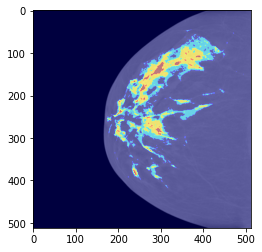

In [27]:
total_epoch = 80
for epoch in range(total_epoch):
    print("-" * 10)
    print(f"epoch {epoch + 1}/{total_epoch}")
    model.train()
    epoch_loss = 0
    step = 0
    for batch_data in train_loader:
        step += 1
        inputs, labels = batch_data[0].to(device), batch_data[1].to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        #outputs = outputs['out']
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        epoch_len = len(train_ds) // train_loader.batch_size
        #print(f"{step}/{epoch_len}, train_loss: {loss.item():.4f}")
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            val_images = None
            val_labels = None
            val_outputs = None
            for val_data in val_loader:
                val_images, val_labels = val_data[0].to(device), val_data[1].to(device)
                #roi_size = (96, 96)
                #sw_batch_size = 4
                val_outputs = model(val_images)
                #val_outputs = val_outputs['out']
                #val_outputs = sliding_window_inference(val_images, roi_size, sw_batch_size, model)
                #val_outputs = [post_trans(i) for i in decollate_batch(val_outputs)]
                val_outputs = post_trans(val_outputs)
                # compute metric for current iteration
                dice_metric(y_pred=val_outputs, y=val_labels)

            # aggregate the final mean dice result
            metric = dice_metric.aggregate().item()
            # reset the status for next validation round
            dice_metric.reset()
            metric_values.append(metric)
            if metric > best_metric:
                best_metric = metric
                best_metric_epoch = epoch + 1
                torch.save(model.state_dict(), path)
                print("saved new best metric model")
            print(
                "current epoch: {} current mean dice: {:.4f} best mean dice: {:.4f} at epoch {}".format(
                    epoch + 1, metric, best_metric, best_metric_epoch
                )
            )
        model.eval()
        plot_predict(model, file)
        #plt.savefig(path_pdf+'epoch'+str(epoch)+'.pdf', format='PDF')
print(f"train completed, best_metric: {best_metric:.4f} at epoch: {best_metric_epoch}")

tmp = pd.DataFrame(zip([i + 1 for i in range(len(epoch_loss_values))], epoch_loss_values), columns = ['epoch','loss'])
tmp = tmp.merge(pd.DataFrame(zip([val_interval * (i + 1) for i in range(len(metric_values))], metric_values), columns = ['epoch','dice']), how='outer')
tmp.to_csv(path_hist, index=False)

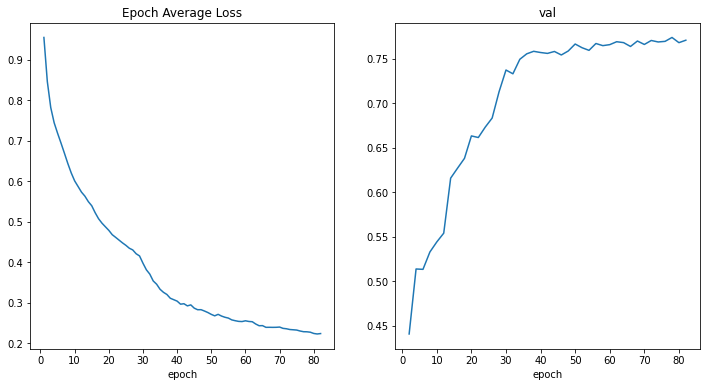

In [28]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Epoch Average Loss")
x = [i + 1 for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.subplot(1, 2, 2)

plt.title("val")
x = [val_interval * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.show()

### Predict

In [29]:
model.load_state_dict(torch.load(path))

<All keys matched successfully>

/home/jslee/miniconda3/lib/python3.9/site-packages/openjpeg/utils.py:176: UserWarning: The (7FE0,0010) Pixel Data contains a JPEG 2000 codestream with the optional JP2 file format header, which is non-conformant to the DICOM Standard (Part 5, Annex A.4.4)
  warnings.warn(


dicom/ncc2020/25225_LCC_19000101.dcm


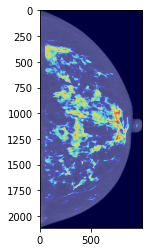

In [30]:
i=random.choice(range(len(density)))
file = 'dicom/'+density.CENTER[i]+'/'+density.file[i]
thres = density[['thres_cu','thres_ac','thres_cc']].values[i].tolist()
final = f.get_final5(file, thres = thres)
print(file)
plot_seg(final[0],final[1])

/home/jslee/miniconda3/lib/python3.9/site-packages/openjpeg/utils.py:176: UserWarning: The (7FE0,0010) Pixel Data contains a JPEG 2000 codestream with the optional JP2 file format header, which is non-conformant to the DICOM Standard (Part 5, Annex A.4.4)
  warnings.warn(


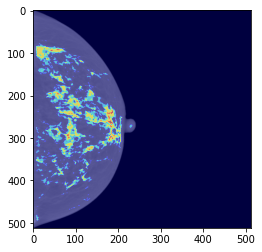

In [31]:
model.eval()
plot_predict(model, file)

## with train_vendor.csv

In [8]:
df_image = pd.read_csv("csv/train_vendor.csv")

In [9]:
df_density = df_image[df_image.dataset_density=="yes"]
len(df_density)

8068

In [10]:
df_density.value_counts("CENTER")

CENTER
ncc2020    5979
asan       2089
dtype: int64

In [16]:
train_imtrans = Compose([LoadImage(image_only=True), AddChannel(), ScaleIntensity()])
train_segtrans = Compose([LoadImage(image_only=True)])
val_imtrans = Compose([LoadImage(image_only=True), AddChannel(), ScaleIntensity()])
val_segtrans = Compose([LoadImage(image_only=True)])

dicom_imtrans = Compose(ScaleIntensity())
post_trans = Compose([Activations(sigmoid=True), AsDiscrete(threshold_values=True)])

In [17]:
images_train = df_density[df_density.dataset=="train"].file_image.tolist()
images_val = df_density[df_density.dataset=="val"].file_image.tolist()
images_test = df_density[df_density.dataset=="test"].file_image.tolist()

segs_train = [re.sub('image','segment',i) for i in images_train]
segs_val = [re.sub('image','segment',i) for i in images_val]
segs_test = [re.sub('image','segment',i) for i in images_test]

In [18]:
check_ds = MyDataset(images_train, train_imtrans, segs_train, train_segtrans)
check_loader = DataLoader(check_ds, batch_size=5)
im, seg = monai.utils.misc.first(check_loader)
print(im.shape, seg.shape)

torch.Size([5, 1, 256, 256]) torch.Size([5, 4, 256, 256])


In [19]:
BATCH_SIZE = 128
train_ds = MyDataset(images_train, train_imtrans, segs_train, train_segtrans)
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=8, pin_memory=torch.cuda.is_available(), drop_last=True)

val_ds = MyDataset(images_val, val_imtrans, segs_val, val_segtrans)
val_loader = DataLoader(val_ds, batch_size=4, num_workers=4, pin_memory=torch.cuda.is_available())

In [20]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = monai.networks.nets.UNet(
    dimensions=2,
    in_channels=1,
    out_channels=4,
    channels=(16, 32, 64, 128, 256),
    strides=(2, 2, 2, 2),
    num_res_units=2,
)

if torch.cuda.device_count() > 1:
    print("Using", torch.cuda.device_count(), "GPUs")
    model = torch.nn.DataParallel(model, device_ids = [0, 1, 2])
model = model.to(device)

Using 3 GPUs


In [21]:
optimizer = torch.optim.Adam(model.parameters(), 1e-3)
loss_function = monai.losses.DiceFocalLoss(sigmoid=True) #lambda_dice=0.5, lambda_focal=1.0
dice_metric = DiceMetric(include_background=True, reduction="mean")

In [22]:
# start a typical PyTorch training
val_interval = 2
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = list()
metric_values = list()

In [23]:
name = 'density-unet_2'
path = "model/"+ name + ".pth"
path_hist = "model/"+ name + ".csv"
path_pdf = "model/"+ name + "/"

5651


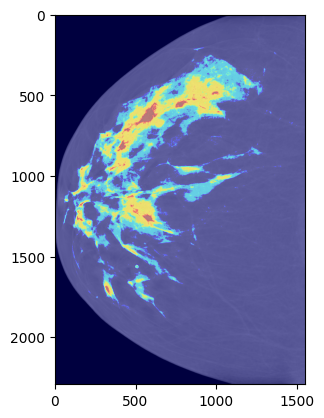

In [24]:
density = pd.read_csv("csv/density_asan-ncc.csv")
#i=random.choice(range(len(density)))
i=5651
print(i)
file = 'dicom/'+density.CENTER[i]+'/'+density.file[i]
thres = density[['thres_cu','thres_ac','thres_cc']].values[i].tolist()
final = f.get_final5(file, thres = thres)
plot_seg(final[0],final[1])
plt.savefig('5651.pdf', format='PDF')

----------
epoch 1/80
epoch 1 average loss: 0.9551
----------
epoch 2/80
epoch 2 average loss: 0.8453
saved new best metric model
current epoch: 2 current mean dice: 0.4403 best mean dice: 0.4403 at epoch 2
----------
epoch 3/80
epoch 3 average loss: 0.7809
----------
epoch 4/80
epoch 4 average loss: 0.7426
saved new best metric model
current epoch: 4 current mean dice: 0.5059 best mean dice: 0.5059 at epoch 4
----------
epoch 5/80
epoch 5 average loss: 0.7173
----------
epoch 6/80
epoch 6 average loss: 0.6932
saved new best metric model
current epoch: 6 current mean dice: 0.5257 best mean dice: 0.5257 at epoch 6
----------
epoch 7/80
epoch 7 average loss: 0.6690
----------
epoch 8/80
epoch 8 average loss: 0.6423
saved new best metric model
current epoch: 8 current mean dice: 0.5378 best mean dice: 0.5378 at epoch 8
----------
epoch 9/80
epoch 9 average loss: 0.6217
----------
epoch 10/80
epoch 10 average loss: 0.6017
saved new best metric model
current epoch: 10 current mean dice: 0.5

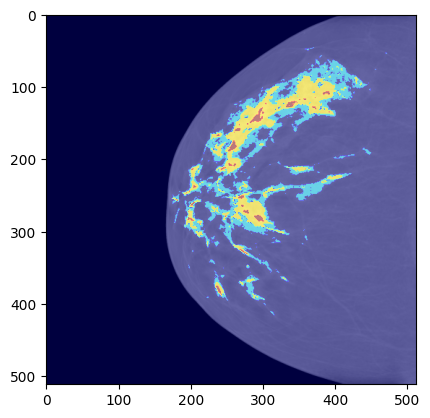

In [25]:
total_epoch = 80
for epoch in range(total_epoch):
    print("-" * 10)
    print(f"epoch {epoch + 1}/{total_epoch}")
    model.train()
    epoch_loss = 0
    step = 0
    for batch_data in train_loader:
        step += 1
        inputs, labels = batch_data[0].to(device), batch_data[1].to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        #outputs = outputs['out']
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        epoch_len = len(train_ds) // train_loader.batch_size
        #print(f"{step}/{epoch_len}, train_loss: {loss.item():.4f}")
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            val_images = None
            val_labels = None
            val_outputs = None
            for val_data in val_loader:
                val_images, val_labels = val_data[0].to(device), val_data[1].to(device)
                #roi_size = (96, 96)
                #sw_batch_size = 4
                val_outputs = model(val_images)
                #val_outputs = val_outputs['out']
                #val_outputs = sliding_window_inference(val_images, roi_size, sw_batch_size, model)
                #val_outputs = [post_trans(i) for i in decollate_batch(val_outputs)]
                val_outputs = post_trans(val_outputs)
                # compute metric for current iteration
                dice_metric(y_pred=val_outputs, y=val_labels)

            # aggregate the final mean dice result
            metric = dice_metric.aggregate().item()
            # reset the status for next validation round
            dice_metric.reset()
            metric_values.append(metric)
            if metric > best_metric:
                best_metric = metric
                best_metric_epoch = epoch + 1
                torch.save(model.state_dict(), path)
                print("saved new best metric model")
            print(
                "current epoch: {} current mean dice: {:.4f} best mean dice: {:.4f} at epoch {}".format(
                    epoch + 1, metric, best_metric, best_metric_epoch
                )
            )
        model.eval()
        plot_predict(model, file)
        #plt.savefig(path_pdf+'epoch'+str(epoch)+'.pdf', format='PDF')
print(f"train completed, best_metric: {best_metric:.4f} at epoch: {best_metric_epoch}")

tmp = pd.DataFrame(zip([i + 1 for i in range(len(epoch_loss_values))], epoch_loss_values), columns = ['epoch','loss'])
tmp = tmp.merge(pd.DataFrame(zip([val_interval * (i + 1) for i in range(len(metric_values))], metric_values), columns = ['epoch','dice']), how='outer')
tmp.to_csv(path_hist, index=False)

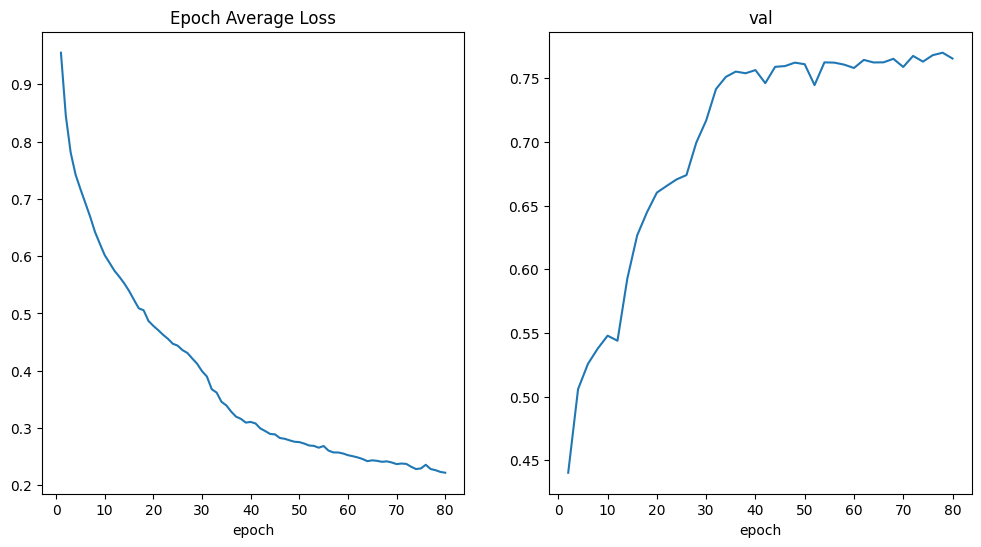

In [26]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Epoch Average Loss")
x = [i + 1 for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.subplot(1, 2, 2)

plt.title("val")
x = [val_interval * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.show()

In [27]:
model.load_state_dict(torch.load(path))

<All keys matched successfully>

dicom/ncc2020/25225_LCC_19000101.dcm


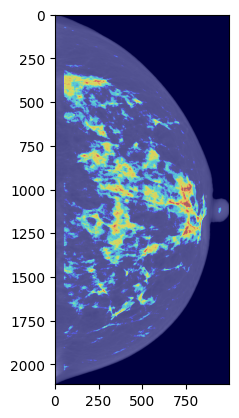

In [28]:
i=random.choice(range(len(density)))
file = 'dicom/'+density.CENTER[i]+'/'+density.file[i]
thres = density[['thres_cu','thres_ac','thres_cc']].values[i].tolist()
final = f.get_final5(file, thres = thres)
print(file)
plot_seg(final[0],final[1])

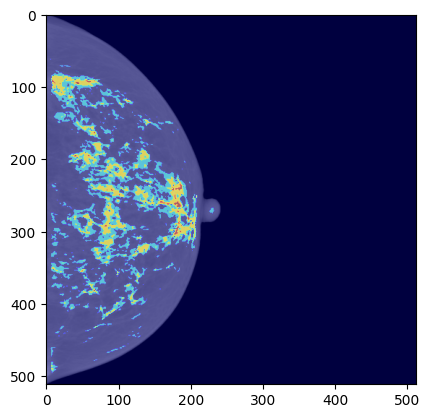

In [29]:
model.eval()
plot_predict(model, file)